<a id = 'title'></a>

# Контекст

Ваша команда внедрила новое решение на сайте — назойливый чат с менеджером. Менеджеры продукта говорят о том, что это вызовет негативный опыт у пользователей, а менеджеры по продажам считают, что так увеличится выручка. Вам пришли результаты A/B теста: одной выборке показывали назойливый чат, а другой — нет. Оцените результаты теста и опишите выводы.

---

## [Исследуйте данные](#stage_1)

- [Требуется ли преобразование типов?](#stage_1_1)
- [Присутствуют ли пропущенные значения и дубликаты? Если да, то какова их природа?](#stage_1_2)
- [Добавить признак день](#stage_1_3)
- [Сбор данных по A/B тестированию: сроки, распределение посетителей по дням, очитска данных (если необходима), кумулятивная доля посетителей по событиям,  кол-во уникальных пользователей (по группам исследования)](#stage_1_4)

---

## [Проведите исследовательский анализ данных](#stage_2)

- [Исследуйте конверсию в воронке на разных этапах?](#stage_2_1)
- [Обладают ли выборки одинаковыми распределениями количества событий на пользователя?](#stage_2_2)
- [Как число событий распределено по дням?](#stage_2_3)
- [Подумайте, есть ли какие-то нюансы данных, которые нужно учесть, прежде чем приступать к A/B-тестированию?](#stage_2_4)
- [Проведите оценку результатов A/B-тестирования](#stage_2_5)
- [Что можно сказать про результаты A/A-тестирования?](#stage_2_6)
- [Проверьте статистическую разницу долей z-критерием](#stage_2_7)

---

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from plotly import graph_objects as go

---

<a id = 'stage_1'></a>

# 1. Исследуйте данные 

[к оглавлению](#title)

---

<a id = 'stage_1_1'></a>

#### 1.1. Требуется ли преобразование типов?

[к оглавлению](#title)

In [60]:
data = pd.read_csv('ab_log.csv')
data.info() # нет пропусков

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154788 entries, 0 to 154787
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   event      154788 non-null  object
 1   user_id    154788 non-null  int64 
 2   EventTime  154788 non-null  int64 
 3   Group      154788 non-null  object
dtypes: int64(2), object(2)
memory usage: 4.7+ MB


In [61]:
data.head()

,event,user_id,EventTime,Group
0,StartReadingOffer,7241586465170049200,1564978321,A2
1,OpenProductCard,4998498972125515821,1564678223,A2
2,StartReadingOffer,5794343176311717876,1564681595,B
3,StartReadingOffer,3371640160394640961,1564635919,A1
4,OpenProductCard,4623191541226589455,1564695060,A1


In [62]:
# Сменим имена колонок, на удобные и поменяет временные данные с unix на datetime64[ns]
data.columns = ['event', 'user_id', 'event_time', 'group']
data['event_time'] = pd.to_datetime(data['event_time'], unit='s')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 154788 entries, 0 to 154787
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event       154788 non-null  object        
 1   user_id     154788 non-null  int64         
 2   event_time  154788 non-null  datetime64[ns]
 3   group       154788 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 4.7+ MB


---

<a id = 'stage_1_2'></a>

#### 1.2. Присутствуют ли пропущенные значения и дубликаты? Если да, то какова их природа?

[к оглавлению](#title)

In [63]:
# проверим наличие дубликатов
data.duplicated().sum()

296

In [64]:
data_dubl = pd.DataFrame(data.duplicated())
index_dubl = data_dubl[data_dubl[0] == True].index

data_dubl = data.loc[index_dubl]
proverka_1 = data_dubl.groupby('user_id')['group'].nunique().unique()
print(f'Сколько у каждого пользователя принадлежностей к группам: {proverka_1}')

Сколько у каждого пользователя принадлежностей к группам: [1]


In [65]:
data = data.drop_duplicates().reset_index(drop = True)  # дроп дубликатов и смена индексов после дропа
data.duplicated().sum() # проверка

0

причиной появления дубликатов может быть ошибка сервера, в целом трудно судить (дубль предполагает совпадение времени в т.ч. Возможно ли, что при обновлении страницы пользователь, таким образом добавил строку в наш датасет (обновил в ту же секунду))

---

<a id = 'stage_1_3'></a>

#### 1.3. Добавить признак: день

[к оглавлению](#title)

In [66]:
data['day'] = pd.to_datetime(data['event_time'].dt.date)
data['day'].unique()

<DatetimeArray>
['2019-08-05 00:00:00', '2019-08-01 00:00:00', '2019-08-02 00:00:00',
 '2019-08-03 00:00:00', '2019-08-04 00:00:00', '2019-07-31 00:00:00',
 '2019-07-30 00:00:00', '2019-07-29 00:00:00', '2019-07-27 00:00:00',
 '2019-07-28 00:00:00', '2019-07-26 00:00:00', '2019-07-25 00:00:00']
Length: 12, dtype: datetime64[ns]

---

<a id = 'stage_1_4'></a>

#### 1.4. Сбор данных по A/B тестированию: сроки, распределение посетителей по дням, очитска данных (если необходима), кумулятивная доля посетителей по событиям,  кол-во уникальных пользователей (по группам исследования)

[к оглавлению](#title)

,day,count
0,2019-08-01,36090
1,2019-08-02,35564
2,2019-08-03,33286
3,2019-08-04,32961
4,2019-08-05,13777
5,2019-07-31,2019
6,2019-07-30,411
7,2019-07-29,184
8,2019-07-28,105
9,2019-07-27,56


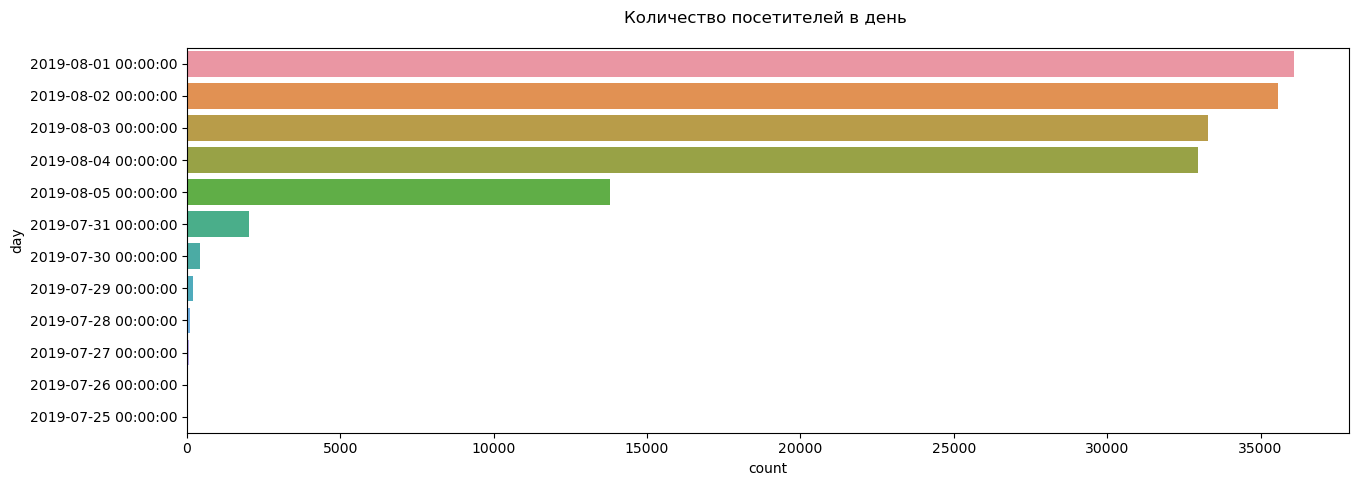

In [67]:
# Кол-во посетителей в день
plt.figure(figsize=(15,5))
sns.barplot(data = data['day'].value_counts().reset_index(),
            x = 'count',
            y = 'day')
plt.title('Количество посетителей в день \n')
data['day'].value_counts().reset_index()

In [68]:
# Посмотрим на кумулятивную долю посетителей
data_for_cum_sum =\
data.groupby('day')['event'].count().reset_index().rename({'event': 'count'}, axis=1)

all_count =data_for_cum_sum['count'].sum()

data_for_cum_sum['percent'] = (data_for_cum_sum['count'] / all_count)*100
data_for_cum_sum['percent_cum_sum'] = data_for_cum_sum['percent'].cumsum()
data_for_cum_sum.round(2)

,day,count,percent,percent_cum_sum
0,2019-07-25,9,0.01,0.01
1,2019-07-26,30,0.02,0.03
2,2019-07-27,56,0.04,0.06
3,2019-07-28,105,0.07,0.13
4,2019-07-29,184,0.12,0.25
5,2019-07-30,411,0.27,0.51
6,2019-07-31,2019,1.31,1.82
7,2019-08-01,36090,23.36,25.18
8,2019-08-02,35564,23.02,48.20
9,2019-08-03,33286,21.55,69.75


Text(0.5, 0, 'count')

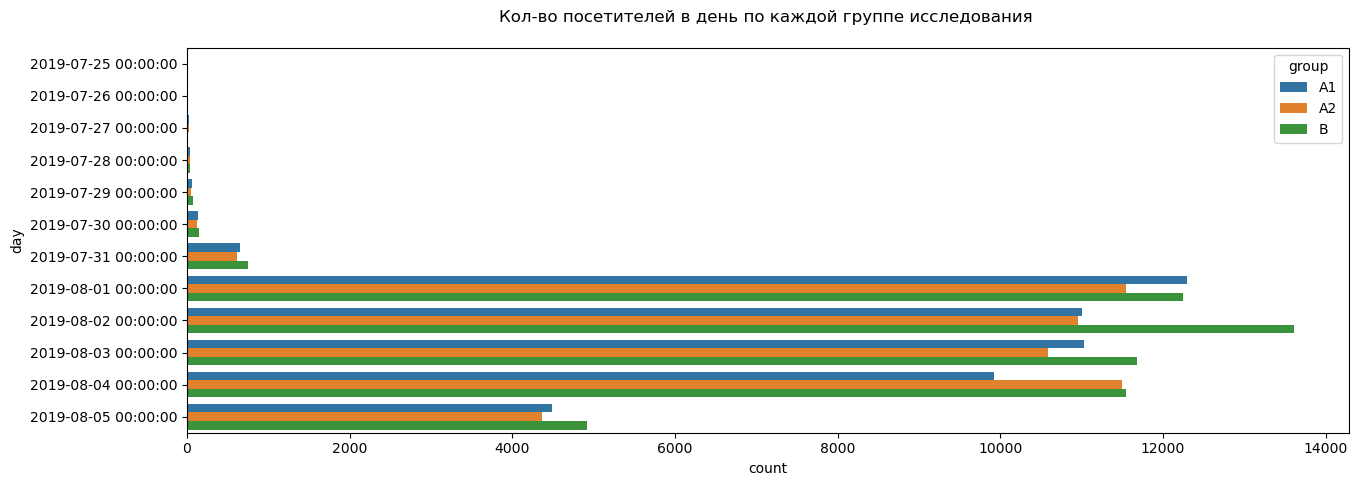

In [69]:
# Кол-во посетителей в день по группам исследования
data_event_group_count =\
data.groupby(['day', 'group'])['event'].count().reset_index()

plt.figure(figsize=(15, 5))
sns.barplot(data_event_group_count,
            x = 'event',
            y = 'day',
            hue = 'group')
plt.title('Кол-во посетителей в день по каждой группе исследования \n')
plt.xlabel('count')

In [70]:
# Очистим данные: оставим только последние 5 дней
data_clear = data[data['day'] > '2019-08-01']
data_clear.info()

<class 'pandas.core.frame.DataFrame'>
Index: 115588 entries, 0 to 154491
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event       115588 non-null  object        
 1   user_id     115588 non-null  int64         
 2   event_time  115588 non-null  datetime64[ns]
 3   group       115588 non-null  object        
 4   day         115588 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 5.3+ MB


In [71]:
# проверим, остались ли события после чистки
data['event'].unique()

array(['StartReadingOffer', 'OpenProductCard', 'StartCheckProduct',
       'OpenPaymentScreen'], dtype=object)

In [72]:
data_clear['event'].unique()

array(['StartReadingOffer', 'StartCheckProduct', 'OpenPaymentScreen',
       'OpenProductCard'], dtype=object)

все четыре события все еще в списке

In [73]:
data_clear.groupby('group')['user_id'].nunique()    # кол-во пользователей вприципе равны

group
A1    2089
A2    2037
B     2101
Name: user_id, dtype: int64

предобработка окончена, все события остались после чистки, группы равномерны распределены (по кол-ву)

---

<a id = 'stage_2'></a>

# 2. Проведите исследовательский анализ данных

[к оглавлению](#title)

---

<a id = 'stage_2_1'></a>

#### 2.1. Исследуйте конверсию в воронке на разных этапах?

[к оглавлению](#title)

In [74]:
# посчитаем кол-во пользователей по каждому событию
data_visitor_count =\
data_clear.groupby('event')['user_id'].count() \
                                      .reset_index() \
                                      .rename({'user_id': 'visitor_event_count'}, axis=1)\
                                      .sort_values(by = 'visitor_event_count', ascending=False)

data_visitor_count

,event,visitor_event_count
3,StartReadingOffer,54338
2,StartCheckProduct,22665
1,OpenProductCard,21135
0,OpenPaymentScreen,17450


In [75]:
# посмотрим на уникальное кол-во посетителей
data_unique_user_count = \
data_clear.groupby('event').agg({'user_id':'nunique'}) \
                           .rename({'user_id':'unique_user_count'}, axis = 1)\
                           .sort_values(by = 'unique_user_count', ascending=False)

data_unique_user_count

,unique_user_count
event,
StartReadingOffer,6072
StartCheckProduct,3638
OpenPaymentScreen,3019
OpenProductCard,2950


In [76]:
# расчет конверсии по событиям
data_unique_user_count['percent'] = (data_unique_user_count['unique_user_count'] / data_unique_user_count['unique_user_count'].sum())*100
data_unique_user_count.round(2)

,unique_user_count,percent
event,,
StartReadingOffer,6072,38.73
StartCheckProduct,3638,23.20
OpenPaymentScreen,3019,19.26
OpenProductCard,2950,18.81


In [77]:
# воронка событий (конверсия)
from plotly import graph_objects as go

fig = go.Figure()
fig = go.Figure(go.Funnel(
    y = data_unique_user_count.reset_index()['event'],
    x = data_unique_user_count.reset_index()['unique_user_count']))
fig.show()

In [78]:
# Рассмотрим воронку событий (конверсию) для каждой отдельной группы исследования

# выделим датасеты групп исследования для последующего анализа
A1_group = data_clear[data_clear['group'] == 'A1']
A2_group = data_clear[data_clear['group'] == 'A2']
B_group = data_clear[data_clear['group'] == 'B']

# Подсчет уникальных посетителей по каждой группе
A1_group_voronka = \
A1_group.groupby('event')['user_id'].nunique() \
                                    .reset_index()\
                                    .sort_values(by = 'user_id', ascending=False)

A2_group_voronka = \
A2_group.groupby('event')['user_id'].nunique() \
                                    .reset_index()\
                                    .sort_values(by = 'user_id', ascending=False)

B_group_voronka = \
B_group.groupby('event')['user_id'].nunique() \
                                   .reset_index()\
                                   .sort_values(by = 'user_id', ascending=False)


# Построение воронки
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'A1',
    y = A1_group_voronka['event'],
    x = A1_group_voronka['user_id'],
    ))

fig.add_trace(go.Funnel(
    name = 'A2',
    y = A2_group_voronka['event'],
    x = A2_group_voronka['user_id'],
    ))

fig.add_trace(go.Funnel(
    name = 'B',
    y = B_group_voronka['event'],
    x = B_group_voronka['user_id'],
    ))

fig.show()


Вывод:

- похожие показатели кол-ва посетителей по каждой группе и каждой стадии воронки
- самое сильное сужение воронки на первом этапе (StartReadingOffer --> StartCheckProduct). Отваливается 41% посетителей
- далее отваливаются 10% и 1% соответственно

---

<a id = 'stage_2_2'></a>

#### 2.2. Обладают ли выборки одинаковыми распределениями количества событий на пользователя?

[к оглавлению](#title)

In [79]:
data_visitor_count

,event,visitor_event_count
3,StartReadingOffer,54338
2,StartCheckProduct,22665
1,OpenProductCard,21135
0,OpenPaymentScreen,17450


In [80]:
data_2_2 =\
A1_group_voronka.merge(data_visitor_count,
                       on = 'event')\
                .rename({'user_id': 'unique_user_A1'}, axis=1)\
                .merge(A2_group_voronka,
                       on = 'event')\
                .rename({'user_id': 'unique_user_A2'}, axis=1)\
                .merge(B_group_voronka,
                       on = 'event')\
                .rename({'user_id': 'unique_user_B'}, axis=1)

data_2_2 = data_2_2[['event', 'visitor_event_count', 'unique_user_A1', 'unique_user_A2', 'unique_user_B']]
data_2_2

,event,visitor_event_count,unique_user_A1,unique_user_A2,unique_user_B
0,StartReadingOffer,54338,2039,1984,2049
1,StartCheckProduct,22665,1204,1227,1207
2,OpenPaymentScreen,17450,1011,1018,990
3,OpenProductCard,21135,982,988,980


In [81]:
# Посмотрим на распределение кол-ва событий по посетителям
data_2_2['events_per_visitor_A1'] = (data_2_2['visitor_event_count'] / data_2_2['unique_user_A1']).round(2)
data_2_2['events_per_visitor_A2'] = (data_2_2['visitor_event_count'] / data_2_2['unique_user_A2']).round(2)
data_2_2['events_per_visitor_B'] = (data_2_2['visitor_event_count'] / data_2_2['unique_user_B']).round(2)
data_2_2

,event,visitor_event_count,unique_user_A1,unique_user_A2,unique_user_B,events_per_visitor_A1,events_per_visitor_A2,events_per_visitor_B
0,StartReadingOffer,54338,2039,1984,2049,26.65,27.39,26.52
1,StartCheckProduct,22665,1204,1227,1207,18.82,18.47,18.78
2,OpenPaymentScreen,17450,1011,1018,990,17.26,17.14,17.63
3,OpenProductCard,21135,982,988,980,21.52,21.39,21.57


да, выборки распределены равномерно

---

<a id = 'stage_2_3'></a>

#### 2.3. Как число событий распределено по дням?

[к оглавлению](#title)

Text(0, 0.5, 'событие')

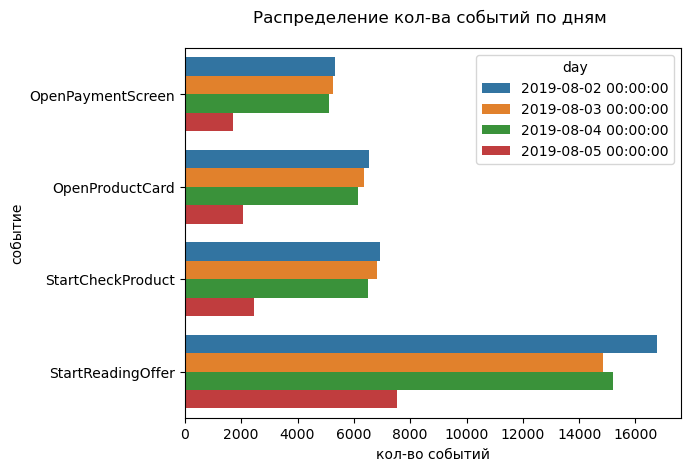

In [82]:
data_2_3 =\
data_clear.groupby(['event', 'day'])['group'].count().reset_index()


sns.barplot(data = data_2_3,
            x = 'group',
            y = 'event',
            hue = 'day')
plt.title('Распределение кол-ва событий по дням \n')
plt.xlabel('кол-во событий')
plt.ylabel('событие')

- события 2,3,4 августа  - распределны одинаково (немного лидурует 2-е августа)
- событий 5 августа меньше минимум в два раза

---

<a id = 'stage_2_4'></a>

#### 2.4. Подумайте, есть ли какие-то нюансы данных, которые нужно учесть, прежде чем приступать к A/B-тестированию?

[к оглавлению](#title)

Условия проведения A/B тестирования:

- группы распределлены равномерно (прмерно одинаковое кол-во в каждой группе)
- посетитель не должен быть в двух и более группах одновременно (только в одной)
- показатели, которые мы мерим с помощью теста берем одинаковые в каждой группе (нельзя измерять средний чек в одно группе и сравнивать с конверсией во второй)

Все это было проверено выше

---

<a id = 'stage_2_6'></a>

#### 2.6. Что можно сказать про результаты A/A-тестирования?

[к оглавлению](#title)

In [83]:
data_unique_visitors=\
data_clear.groupby('group')['user_id'].nunique()\
                                      .reset_index()\
                                      .rename({'user_id': 'unique_user'}, axis = 1)
data_unique_visitors


,group,unique_user
0,A1,2089
1,A2,2037
2,B,2101


In [84]:
data_2_2

,event,visitor_event_count,unique_user_A1,unique_user_A2,unique_user_B,events_per_visitor_A1,events_per_visitor_A2,events_per_visitor_B
0,StartReadingOffer,54338,2039,1984,2049,26.65,27.39,26.52
1,StartCheckProduct,22665,1204,1227,1207,18.82,18.47,18.78
2,OpenPaymentScreen,17450,1011,1018,990,17.26,17.14,17.63
3,OpenProductCard,21135,982,988,980,21.52,21.39,21.57


In [85]:
H0 = 'НЕТ отличия между группами A1 и A2'
H1 = 'ЕСТЬ отличие между группами A1 и A2'

def z_test(kol_vo_1, # числитель первой доли
           kol_vo_2, # числитель второй доли
           all__kol_vo_1,   # знаменатель первой доли
           all__kol_vo_2,   # знаменатель второй доли
           alpha):  # уровень значимости
    
    '''
    Формулировка гипотез должна быть следующая: 

    H0: две доли РАВНЫ
    H1: две доли НЕ РАВНЫ ( Или величина одной выборки больше/меньше величины другой )
    '''
    

    dolya_1 = kol_vo_1 / all__kol_vo_1
    dolya_2 = kol_vo_2 / all__kol_vo_2
    diff = dolya_1 - dolya_2
    dolya_combo = (kol_vo_1 + kol_vo_2) / (all__kol_vo_1 + all__kol_vo_2)

    z_value = diff / np.sqrt(dolya_combo*(1-dolya_combo)*((1/all__kol_vo_1) + (1/all__kol_vo_2)))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    '''print('Используем Z-критерий для двух долей')
    print('Данные статистического теста:')
    print(f'Статистика: {z_value.round(2)}')
    print(f'p-значение: {p_value.round(2)}')
    print(f'Уровень значимости (граничный): {alpha}')
    print('\n')
    print('Итог теста:')'''
    if p_value < alpha:
        '''print(f'На уровне значимости {alpha} - отвергаем нулевую гипотезу')
        print(H1)'''
        itog = H1
    else:
        '''print('Не получилось отвергнуть нулевую гипотезу')
        print(H0)'''
        itog = H0
    
    slovar = {'z_value': z_value[0],
              'p_value': p_value[0],
              'alpha': alpha,
              'Итог': itog}
    data_z_test = pd.Series(slovar)
    return data_z_test

In [86]:
spisok = []
for event_name in data_2_2['event']:
    data_zicl = \
    pd.DataFrame(
    z_test(kol_vo_1 = data_2_2[data_2_2['event'] == event_name]['unique_user_A1'].values,
           kol_vo_2 = data_2_2[data_2_2['event'] == event_name]['unique_user_A2'].values,
           all__kol_vo_1 = data_unique_visitors[data_unique_visitors['group'] == 'A1']['unique_user'].values,
           all__kol_vo_2 = data_unique_visitors[data_unique_visitors['group'] == 'A2']['unique_user'].values,
           alpha = 0.05),
    columns = [f'A1 и A2. Событие {event_name}'])
    spisok.append(data_zicl)

pd.concat(spisok, axis = 1)

,A1 и A2. Событие StartReadingOffer,A1 и A2. Событие StartCheckProduct,A1 и A2. Событие OpenPaymentScreen,A1 и A2. Событие OpenProductCard
z_value,0.428927,-1.697437,-1.01437,-0.960917
p_value,0.667977,0.089614,0.310406,0.336594
alpha,0.05,0.05,0.05,0.05
Итог,НЕТ отличия между группами A1 и A2,НЕТ отличия между группами A1 и A2,НЕТ отличия между группами A1 и A2,НЕТ отличия между группами A1 и A2


Провели A/A тест пройден, доли равномеры, различий между группами исследования нет (на уроне значимости 0.05). Можно приступать к A/B тестированию

---

<a id = 'stage_2_5'></a>

#### 2.5. Проведите оценку результатов A/B-тестирования

[к оглавлению](#title)

In [87]:
# Посмотрим на z-тест A1 и B исследовательских групп

H0 = 'НЕТ отличия между группами A1 и B'
H1 = 'ЕСТЬ отличие между группами A1 и B'

spisok_A1_B = []
for event_name in data_2_2['event']:
    data_A1_B =\
    pd.DataFrame(
    z_test(kol_vo_1 = data_2_2[data_2_2['event'] == event_name]['unique_user_A1'].values,
           kol_vo_2 = data_2_2[data_2_2['event'] == event_name]['unique_user_B'].values,
           all__kol_vo_1 = data_unique_visitors[data_unique_visitors['group'] == 'A1']['unique_user'].values,
           all__kol_vo_2 = data_unique_visitors[data_unique_visitors['group'] == 'B']['unique_user'].values,
           alpha = 0.05),
    columns = [f'A1 и B. Событие: {event_name}'])
    spisok_A1_B.append(data_A1_B)

pd.concat(spisok_A1_B,
          axis = 1)

,A1 и B. Событие: StartReadingOffer,A1 и B. Событие: StartCheckProduct,A1 и B. Событие: OpenPaymentScreen,A1 и B. Событие: OpenProductCard
z_value,0.171202,0.122052,0.82675,0.235888
p_value,0.864065,0.902858,0.408379,0.81352
alpha,0.05,0.05,0.05,0.05
Итог,НЕТ отличия между группами A1 и B,НЕТ отличия между группами A1 и B,НЕТ отличия между группами A1 и B,НЕТ отличия между группами A1 и B


In [88]:
# Посмотрим на z-тест A2 и B исследовательских групп

H0 = 'НЕТ отличия между группами A2 и B'
H1 = 'ЕСТЬ отличие между группами A2 и B'


spisok_A2_B = []
for event_name in data_2_2['event']:
    data_A1_B =\
    pd.DataFrame(
    z_test(kol_vo_1 = data_2_2[data_2_2['event'] == event_name]['unique_user_A2'].values,
           kol_vo_2 = data_2_2[data_2_2['event'] == event_name]['unique_user_B'].values,
           all__kol_vo_1 = data_unique_visitors[data_unique_visitors['group'] == 'A2']['unique_user'].values,
           all__kol_vo_2 = data_unique_visitors[data_unique_visitors['group'] == 'B']['unique_user'].values,
           alpha = 0.05),
    columns = [f'A2 и B. Событие: {event_name}'])
    spisok_A2_B.append(data_A1_B)

pd.concat(spisok_A2_B,
          axis = 1)

,A2 и B. Событие: StartReadingOffer,A2 и B. Событие: StartCheckProduct,A2 и B. Событие: OpenPaymentScreen,A2 и B. Событие: OpenProductCard
z_value,-0.259417,1.821024,1.837146,1.196642
p_value,0.795314,0.068603,0.066188,0.231446
alpha,0.05,0.05,0.05,0.05
Итог,НЕТ отличия между группами A2 и B,НЕТ отличия между группами A2 и B,НЕТ отличия между группами A2 и B,НЕТ отличия между группами A2 и B


In [89]:
# Посмотрим на z-тест A1+A2 и B исследовательских групп

# Выделяем нужные данные
data_2_2_A1_A2_sum = data_2_2.set_index('event').iloc[:,2:4]
data_2_2_A1_A2_sum['A1+A2'] = data_2_2_A1_A2_sum.apply(lambda x: x.sum(), axis=1)
data_2_2_A1_A2_sum = data_2_2_A1_A2_sum.reset_index()
data_2_2_A1_A2_sum

,event,unique_user_A2,unique_user_B,A1+A2
0,StartReadingOffer,1984,2049,4033
1,StartCheckProduct,1227,1207,2434
2,OpenPaymentScreen,1018,990,2008
3,OpenProductCard,988,980,1968


In [90]:
H0 = 'НЕТ отличия между группами A1+A2 и B'
H1 = 'ЕСТЬ отличие между группами A1+A2 и B'


spisok_A1plusA2_B = []
for event_name in data_2_2['event']:
    data_A1_B =\
    pd.DataFrame(
    z_test(kol_vo_1 = data_2_2_A1_A2_sum[data_2_2_A1_A2_sum['event'] == event_name]['A1+A2'].values,
           kol_vo_2 = data_2_2[data_2_2['event'] == event_name]['unique_user_B'].values,
           all__kol_vo_1 = data_unique_visitors[data_unique_visitors['group'] == 'A2']['unique_user'].values + data_unique_visitors[data_unique_visitors['group'] == 'A1']['unique_user'].values,
           all__kol_vo_2 = data_unique_visitors[data_unique_visitors['group'] == 'B']['unique_user'].values,
           alpha = 0.05),
    columns = [f'A2 и B. Событие: {event_name}'])
    spisok_A1plusA2_B.append(data_A1_B)

pd.concat(spisok_A1plusA2_B,
          axis = 1)

,A2 и B. Событие: StartReadingOffer,A2 и B. Событие: StartCheckProduct,A2 и B. Событие: OpenPaymentScreen,A2 и B. Событие: OpenProductCard
z_value,0.546799,1.168255,1.154881,0.786939
p_value,0.584517,0.242704,0.248139,0.431318
alpha,0.05,0.05,0.05,0.05
Итог,НЕТ отличия между группами A1+A2 и B,НЕТ отличия между группами A1+A2 и B,НЕТ отличия между группами A1+A2 и B,НЕТ отличия между группами A1+A2 и B


 - Нельзя делать вывод о различии долей --> назойливый чат с менеджером не влияет на посещение сайта (передвижение по воронке событий).
 - ВАЖНО! Это вывод сделанный на основе 5 дней сбора информации. Вывод о влиянии этого назоливого чата в долгосрочной перспективе делать нельзя


Итог:

- назойливый чат вводить не стоит (либо организовать длительное A/B тестирование)
- продумать варианты устранения сильного сужения воронки событий на первом и втором этапе